In [1]:
exclude_models = [] # list of 4 digit hexa string or empty list

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json
import yaml
from IPython.display import *
import ipywidgets as widgets
from ipywidgets import *
from IPython.display import Image, display
from LRFutils import progress
from scipy.optimize import curve_fit
import tensorflow as tf
from src import physical_models

2023-05-14 17:35:37.230177: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-14 17:35:37.386180: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-14 17:35:37.386204: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-14 17:35:37.424212: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-14 17:35:38.207224: W tensorflow/stream_executor/platform/de

# Load models

In [3]:
class Model:
    def __init__(self, **data):
        for key in data:
            try:
                value = data[key].item()
            except:
                value = data[key]
            setattr(self, key, value)

        self.id = self.model_id


        # Inference -------------------------------------------------------------------
        
        self.expectations = {}
        self.predictions = {}

        for label in self.inference.keys():
            self.expectations[label] = []
            self.predictions[label] = []

            for i in range(len(self.inference[label])):
                self.expectations[label].append(self.inference[label][i]["expectation"])
                self.predictions[label].append(self.inference[label][i]["predictions"])

    def add_inference(self, label, expectation, predictions):

        if label not in self.inference:
            self.inference[label] = []
        if label not in self.expectations:
            self.expectations[label] = []
        if label not in self.predictions:
            self.predictions[label] = []

        self.inference[label].append({"expectation":expectation, "predictions":predictions})
        self.expectations[label].append(expectation)
        self.predictions[label].append(predictions)

In [4]:
def load_model(archive_path):

    metadata = dict(np.load(archive_path + "/metadata.npz", allow_pickle=True))
    model = tf.keras.models.load_model(archive_path + "/model.h5")
    inference = dict(np.load(archive_path + "/inference.npz", allow_pickle=True))
    test_set = dict(np.load(archive_path + "/test_set.npz", allow_pickle=True))

    model = Model(**metadata, **inference, **test_set, model=model, archive_path=archive_path)

    return model

In [5]:
# Loading models

# Getting list of model's archive path
source = f"data/model_comparison/model_list.yml"
with open(source) as f:
    archives = yaml.safe_load(f)

# Loading models
all_models = {}
for archive in archives.values():

    try:
        model = load_model(archive)
        all_models[model.id] = model
        print("Loaded model", model.id, ":", archive + "/model.png")
        
    except Exception as e:
        print("Failed to load model contained in", archive)
        raise e

2023-05-14 17:35:40.017735: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-14 17:35:40.017774: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-14 17:35:40.017805: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cluster16): /proc/driver/nvidia/version does not exist
2023-05-14 17:35:40.018116: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loaded model 0001 : ./archives/2023-05-14_c91d7c8/52/model.png


In [6]:
# Selecting model to compare

models = {}
def update_model_list_select(*args):
    global models
    models = {}
    for key in model_list_select.value:
        models[key] = all_models[key]

model_list_select = widgets.SelectMultiple(
    options=list(all_models.keys()),
    value=list(all_models.keys()),
    description='Models',
    disabled=False
)

model_list_select.observe(update_model_list_select)
display(model_list_select)
update_model_list_select()

SelectMultiple(description='Models', index=(0,), options=('0001',), value=('0001',))

# Model detail

Dropdown(description='Model ID: ', options=('0001',), value='0001')

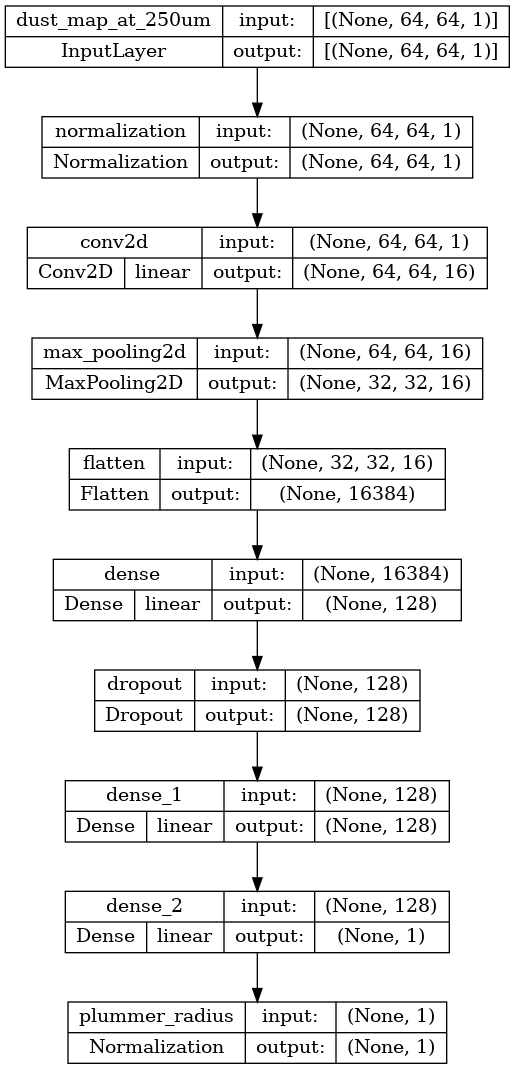

Total params: 2,114,337
Trainable params: 2,114,337
Non-trainable params: 0
_________________________________________________________________

Optimizer: adam
Loss: mean_squared_error
Metric: MAE

Epochs: 1000
Batch size: 100

Training time: 3m 16.97s

Validation fraction: 20 %
Test fraction: 10 %

Path: ./archives/2023-05-14_c91d7c8/52



In [7]:
# Select model and view details

def print_model_details(id):

    model = all_models[id]

    display(Image(filename=f'{model.archive_path}/model.png'))
    print("\n".join(model.summary[-4:]))

    print("")
    print("Optimizer:", model.optimizer)
    if isinstance(model.loss, list):
        print("Loss:\n -", "\n - ".join(model.loss))
    else:
        print("Loss:", model.loss)
    if isinstance(model.metrics, str):
        print("Metric:", model.metrics)
    else:
        print("Metrics:\n -", "\n - ".join(model.metrics))
    print("")
    print("Epochs:", model.epochs)
    print("Batch size:", model.batch_size)
    print("")
    print(f"Training time: {int(model.training_time//60)}m {model.training_time%60:.2f}s" )
    if hasattr(model, "scores"):
        print("Score:\n -", "\n - ".join([f"{i:.2e}" for i in model.scores]))
    print("")
    # print("Dataset size:", details['dataset_size'])
    print("Validation fraction:", int(model.val_frac * 100), "%")
    print("Test fraction:", int(model.test_frac * 100), "%")
    print("")
    print("Path:", archive)
    print("")
    if hasattr(model, "inputs"):
        print("Inputs:\n -", "\n - ".join(model.inputs))
    if hasattr(model, "outputs"):
        print("Outputs:\n -", "\n - ".join(model.outputs))

options = []
for model in all_models.values():
    options.append(model.id)

selected_model = options[0]

model_widget = Dropdown(options=options, value=options[0], description="Model ID: ")

# Define a function that updates the content of y based on what we select for x
def update_model_widget(*args):
    global selected_model
    clear_output()
    display(model_widget)
    print_model_details(model_widget.value)
    selected_model = all_models[model_widget.value]

model_widget.observe(update_model_widget)
update_model_widget()

# Training evolution

In [10]:
# Plot training evolution

# Looking at how many different val metrics are available
nb_metrics = 0
seen_metrics = []
for model_id, model in models.items():
    for key in model.history.keys():
        if key.startswith("val_") and not key.endswith("loss") and key not in seen_metrics:
            seen_metrics.append(key)
            nb_metrics += 1

fig, axs = plt.subplots(nb_metrics, 3, figsize=(20, 5*nb_metrics))
if not isinstance(axs, list):
    axs = [axs]

for model_id, model in models.items():

    time_range = np.linspace(0, model.training_time, model.epochs, endpoint=True)

    # Printing loss
    for i, key in enumerate(seen_metrics):
        if key in model.history:
            for ax in axs[i]:
                curve = model.history[key]
                ax.plot(time_range, curve, alpha=0.5, label=f"Model {model.id}")


for i, row in enumerate(axs):
    for ax in row:
        ax.set_title(seen_metrics[i])
        ax.set_ylabel(seen_metrics[i])
        ax.set_xlabel('Time (s)')
        ax.legend()
    row[1].set_yscale('log')
    row[2].set_xscale('log')
    row[2].set_yscale('log')

plt.show()

# Data completion

## Plummer profile -> parameters

In [ ]:
# Model completion | Plummer profile 1D -> Plummer parameters

space_range = np.linspace(-25, 25, 64, endpoint=True)

def plummer_profile_to_parameter():
    global all_models; space_range

    treated_models = []

    for model_id, model in all_models.items():

        print(model.inference.keys())

        # Ignoring models that does not have the Plummer profile or that already have the parameters
        if not "plummer_profile_1D" in model.inference \
                or "plummer_max"    in model.inference \
                or "plummer_radius" in model.inference \
                or "plummer_slope"  in model.inference:
            continue

        treated_models.append(model_id)

        # Computing the Plummer parameters associated to each profile
        model.inference["plummer_max"]    = []
        model.inference["plummer_radius"] = []
        model.inference["plummer_slope"]  = []
        bar = progress.Bar(len(model.inference["plummer_profile_1D"]), prefix=f"Fitting plummer on {model.id}")
        i=0
        for output in model.inference["plummer_profile_1D"]:
            expectation, predictions = output["expectation"], output["predictions"]

            param = [1e4, 2, 1]
            expectation_popt, _ = curve_fit(physical_models.plummer, space_range, expectation, p0=param, maxfev = 100000)
            expectation_max = np.array([expectation_popt[0]])
            expectation_radius = np.array([expectation_popt[1]])
            expectation_slope = np.array([expectation_popt[2]])

            predictions_max = []
            predictions_radius = []
            predictions_slope = []
            for prediction in predictions:
                try:
                    popt, _ = curve_fit(physical_models.plummer, space_range, prediction, p0=param, maxfev = 100000)
                    predictions_max.append(np.array([popt[0]]))
                    predictions_radius.append(np.array([popt[1]]))
                    predictions_slope.append(np.array([popt[2]]))
                except:
                    pass

            model.add_inference("plummer_max", expectation_max, predictions_max)
            model.add_inference("plummer_radius", expectation_radius, predictions_radius)
            model.add_inference("plummer_slope", expectation_slope, predictions_slope)

            i+=1
            bar(i)

    return treated_models

profile_to_param_models = plummer_profile_to_parameter()
print(profile_to_param_models)

In [ ]:
# Plotting comparison

if len(profile_to_param_models) > 0:

    profile_to_param_model_dropdown = Dropdown(options=profile_to_param_models, value=profile_to_param_models[0], description="Model: ")

    def get_profile_to_param_result_slider():
        global profile_to_param_model_dropdown
        model = all_models[profile_to_param_model_dropdown.value]
        return IntSlider(
            value=0,
            min=0,
            max=len(model.inference["plummer_profile_1D"])-1,
            step=1,
            description='Test:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='d',
            width='100%',
            layout=Layout(width='100%') 
        )

    profile_to_param_result_slider = get_profile_to_param_result_slider()

    def plot_profile_to_param(*args):
        global profile_to_param_model_dropdown, space_range, previous_button, next_button, profile_to_param_result_slider

        model = all_models[profile_to_param_model_dropdown.value]
        r = profile_to_param_result_slider.value

        clear_output()
        display(profile_to_param_model_dropdown)
        display(profile_to_param_result_slider)

        expectation = model.expectations["plummer_profile_1D"][r]
        prediction_max = np.max(model.predictions["plummer_profile_1D"][r], axis=0)
        prediction_mean = np.mean(model.predictions["plummer_profile_1D"][r], axis=0)
        prediction_min = np.min(model.predictions["plummer_profile_1D"][r], axis=0)

        plt.figure(figsize=(15, 5))

        plt.plot(space_range, expectation, c="b", label="Expectation")
        plt.plot(space_range, prediction_max, c="y", label="Prediction")
        plt.plot(space_range, prediction_mean, c="y")
        plt.plot(space_range, prediction_min, c="y")
        plt.fill(np.concatenate([space_range, space_range[::-1]]), np.concatenate([prediction_max, prediction_min[::-1]]), alpha=.3, c="y")


        param = [1,2, 1]
        popt, pcov = curve_fit(physical_models.plummer, space_range, prediction_mean, p0=param, maxfev = 100000)
        fit = physical_models.plummer(space_range, *popt)
        plt.plot(space_range, fit, c="g", label="Fit")
        # print(f"M = {popt[0]}, d = {popt[1]}, p = {popt[2]}")

        plt.title(
            f'Test vector: {r},   '
            + f'$n_H$={float(model.expectations["plummer_max"][r]):.2e},   '\
            + f'$r$={float(model.expectations["plummer_radius"][r]):.2e},   '\
            + f'$p$={float(model.expectations["plummer_slope"][r]):.2e}'
        )
        plt.legend()

        plt.show()

    def update_profile_to_param_result(*args):
        global profile_to_param_result
        profile_to_param_result = get_profile_to_param_result_slider()
        plot_profile_to_param()

    profile_to_param_model_dropdown.observe(update_profile_to_param_result)
    profile_to_param_result_slider.observe(plot_profile_to_param)

    plot_profile_to_param()

## Plummer parameters -> profile

In [ ]:
# Model completion | Plummer parameters -> Plummer profile 1D

def plummer_parameter_to_profile():
    global all_models, space_range

    treated_models = []

    for model_id, model in all_models.items():

        # Ignoring models that does not have the Plummer parameters or that already have the profile
        if "Plummer_profile_1D" in model.inference \
                or not "Plummer_max"    in model.inference \
                or not "Plummer_radius" in model.inference \
                or not "Plummer_slope"  in model.inference:
            continue

        treated_models.append(model.id)

        # Computing the Plummer parameters associated to each profile
        model.inference["Plummer_profile_1D"]    = []
        bar = progress.Bar(len(model.inference["Plummer_max"]), prefix=f"Fitting plummer on {model.id}")

        for i in range(len(model.inference["Plummer_max"])):

            expectation_max = model.expectations["Plummer_max"][i]
            expectation_radius = model.expectations["Plummer_radius"][i]
            expectation_slope = model.expectations["Plummer_slope"][i]

            expectation_profile = physical_models.plummer(space_range, expectation_max, expectation_radius, expectation_slope)

            predictions_profile = []
            for j in range(len(model.predictions["Plummer_max"][i])):

                prediction_max = model.predictions["Plummer_max"][i][j]
                prediction_radius = model.predictions["Plummer_radius"][i][j]
                prediction_slope = model.predictions["Plummer_slope"][i][j]
                
                profile = physical_models.plummer(space_range, prediction_max, prediction_radius, prediction_slope)

                predictions_profile.append(profile)

            model.add_inference("Plummer_profile_1D", expectation_profile, predictions_profile)

            bar(i+1)

    return treated_models

param_to_profile_models = plummer_parameter_to_profile()  
print(param_to_profile_models)        

In [ ]:
# Plotting comparison

if len(param_to_profile_models) > 0:

    param_to_profile_model_dropdown = Dropdown(options=param_to_profile_models, value=param_to_profile_models[0], description="Model: ")

    def get_param_to_profile_result_slider():
        global profile_to_param_model_dropdown
        model = all_models[param_to_profile_model_dropdown.value]
        return IntSlider(
            value=0,
            min=0,
            max=len(model.inference["Plummer_profile_1D"])-1,
            step=1,
            description='Test:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='d',
            width='100%',
            layout=Layout(width='100%') 
        )

    param_to_profile_result_slider = get_param_to_profile_result_slider()

    def plot_param_to_profile(*args):
        global param_to_profile_model_dropdown, space_range, previous_button, next_button, param_to_profile_result_slider

        model = all_models[param_to_profile_model_dropdown.value]
        r = profile_to_param_result_slider.value

        clear_output()
        display(param_to_profile_model_dropdown)
        display(param_to_profile_result_slider)

        expectation = model.expectations["Plummer_profile_1D"][r]
        prediction_max = np.max(model.expectations["Plummer_profile_1D"][r], axis=0)
        prediction_mean = np.mean(model.expectations["Plummer_profile_1D"][r], axis=0)
        prediction_min = np.min(model.expectations["Plummer_profile_1D"][r], axis=0)

        plt.figure(figsize=(15, 5))

        expectation = model.expectations["Plummer_profile_1D"][r]
        prediction_max = np.max(model.predictions["Plummer_profile_1D"][r], axis=0)
        prediction_mean = np.mean(model.predictions["Plummer_profile_1D"][r], axis=0)
        prediction_min = np.min(model.predictions["Plummer_profile_1D"][r], axis=0)

        plt.plot(space_range, expectation, c="b", label="Expectation")
        plt.plot(space_range, prediction_max, c="y", label="Prediction")
        plt.plot(space_range, prediction_mean, c="y")
        plt.plot(space_range, prediction_min, c="y")
        plt.fill(np.concatenate([space_range, space_range[::-1]]), np.concatenate([prediction_max, prediction_min[::-1]]), alpha=.3, c="y")

        plt.title(
            f'Test vector {r},   '
            + f'$n_H$={float(model.expectations["Plummer_max"][r]):.2e},   '\
            + f'$r$={float(model.expectations["Plummer_radius"][r]):.2e},   '\
            + f'$p$={float(model.expectations["Plummer_slope"][r]):.2e}'
        )

        plt.legend()
        plt.show()

    def update_param_to_profile_result(*args):
        global param_to_profile_result
        param_to_profile_result = get_param_to_profile_result_slider()
        plot_param_to_profile()

    param_to_profile_model_dropdown.observe(update_param_to_profile_result)
    param_to_profile_result_slider.observe(plot_param_to_profile)

    plot_param_to_profile()

# Violin plot

In [ ]:
# Violin plot def

def violin_plot(output, model_list, limits):
    plt.figure(figsize=(20, 10))

    labels = []
    def add_label(violin, label):
        color = violin["bodies"][0].get_facecolor().flatten()
        labels.append((mpatches.Patch(color=color), label))

    i = 0
    ignored_models = []
    for key in model_list:
        model = models[key]

        if output not in model.inference:
            ignored_models.append(key)
            continue

        expectations = np.array(model.expectations[output])
        predictions = np.array(model.predictions[output])

        print(key)
        print(expectations.shape)
        print(predictions.shape)

        expectations = expectations.flatten()
        dim_order = list(range(len(predictions.shape)))
        dim_order.pop(1)
        dim_order.append(1)
        predictions = np.transpose(predictions, dim_order)
        N = predictions.shape[-1]
        S = predictions.size
        predictions = predictions.reshape((S//N,N)).T
        
        vmin = float(limits[0])
        vmax = float(limits[1])
        eps = (float(limits[1]) - float(limits[0])) * 0.01

        mask = (expectations + eps >= vmin) & (expectations - eps <= vmax)
        expectations = np.sort(expectations[mask], axis=0)
        predictions = np.sort(predictions[:,mask], axis=1)
        plt.scatter(expectations, expectations, color="k", alpha=1, s=10)

        # grouping expectations
        group_width = 1/20 * (np.max(expectations)-np.min(expectations))
        grouped_expectations = [expectations[0]]
        grouped_predictions = [predictions[:,0]]
        cpt = 1
        for i, expectation in enumerate(expectations):
            if i==0:
                continue
            if expectation - group_width < grouped_expectations[-1]:
                grouped_predictions[-1] += predictions[:,i]
                cpt += 1
            else:
                grouped_predictions[-1] /= cpt
                grouped_expectations.append(expectation)
                grouped_predictions.append(predictions[:,i])
                cpt = 1
        grouped_predictions[-1] /= cpt

        expectations = np.array(grouped_expectations)
        predictions = np.array(grouped_predictions).T

        emin = np.min(expectations)
        emax = np.max(expectations)

        plt.plot([emin,emax],[emin,emax], c="black", linewidth=1)

        violin_parts = plt.violinplot(
            dataset=predictions[:,:],
            positions=expectations[:], 
            widths=(np.max(expectations)-np.min(expectations))*0.05, showmeans=True, showextrema=False
        )

        add_label(violin_parts, f"Model {key}")

    if len(ignored_models) > 0:
        print(f"Ignored models that doens't have the {output} output: {', '.join(ignored_models)}")
 
    plt.title(f'Model predictions on {output}')
    plt.ylabel('Predictions')
    plt.xlabel('Expected')
    plt.ticklabel_format(axis="both", style='sci', scilimits=(0,0))
    plt.grid()
    plt.legend(*zip(*labels), loc=2)
    plt.show()

In [ ]:
# Show violin plot

# Second model filter------------------------------------------------------------------------

plot_model_list_select = widgets.SelectMultiple(
    options=list(models.keys()),
    value=list(models.keys()),
    description='Plot models',
    disabled=False
)

# Select output among the possible  ---------------------------------------------------------

def get_output_dropdown():
    possible_outputs = []
    for key in plot_model_list_select.value:
        for output_label in models[key].inference.keys():
            if output_label not in possible_outputs:
                possible_outputs.append(output_label)
    return Dropdown(options=possible_outputs, value=possible_outputs[0], description="Output: "), possible_outputs
output_dropdown, possible_outputs = get_output_dropdown()

# Select range of expectations in the output value's space ----------------------------------

def get_expectation_slider():
    possible_expectations = np.array([])
    for model in models.values():
        if output_dropdown.value not in model.inference:
            continue

        expectations = np.array(model.expectations[output_dropdown.value])
        possible_expectations = np.concatenate((
            possible_expectations,
            expectations.flatten()
        ))
    possible_expectations = list(map(lambda x: f"{x:.2e}", np.sort(possible_expectations).tolist()))
    return widgets.SelectionRangeSlider(
        options=possible_expectations,
        index=(0, len(possible_expectations)-1),
        description='Range',
        disabled=False,
        width='100%',
        layout=Layout(width='100%')  
    )
expectation_slider = get_expectation_slider()

# Plot button ------------------------------------------------------------------------------

plot_button = widgets.Button(
    description='Plot',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)

# Update GUI on action ---------------------------------------------------------------------

def update_gui(*args):
    clear_output()
    display(plot_model_list_select)
    display(output_dropdown)
    display(expectation_slider)
    display(plot_button)

def update_expectation_slider(*args):
    global expectation_slider
    expectation_slider = get_expectation_slider()
    update_gui()

def update_output_dropdown(*args):
    global expectation_slider, output_dropdown, possible_outputs, plot_model_list_select
    new_output_dropdown, new_possible_outputs = get_output_dropdown()
    if possible_outputs != new_possible_outputs:
        old_select = output_dropdown.value
        output_dropdown, possible_outputs = new_output_dropdown, new_possible_outputs
        if old_select in possible_outputs:
            output_dropdown.value = old_select
        else:
            expectation_slider = get_expectation_slider()
        update_gui()

def update_violin_plot(*args):
    update_gui()
    violin_plot(output_dropdown.value, plot_model_list_select.value, expectation_slider.value)
    
plot_model_list_select.observe(update_output_dropdown)
output_dropdown.observe(update_expectation_slider)
plot_button.on_click(update_violin_plot)
update_violin_plot()


# Compare first vector prediction

In [ ]:
path = os.listdir("data/dataset")[0]

data = np.load("data/dataset/" + path)

n_H = np.array([data["n_H"]]),
r = np.array([data["r"]]),
p = np.array([data["p"]]),
profile = plummer_profile_1D = physical_models.plummer(
    space_range=data["space_range"],
    max=data["n_H"],
    radius=data["r"],
    slope=data["p"],
)

dust_map = data["dust_cube"][len(data["dust_cube"])//2,:,:].reshape(*data["dust_cube"].shape[1:], 1)
input = {"Dust_map_at_250um" : np.expand_dims(dust_map, axis=0)}

print(profile_to_param_models)

compare = [
    # (profile, paramters)
    ("0000","0007", "2xD32"),
    ("0001","0006", "2xD128"),
    ("0003","0005", "C16 + 2xD32"),
    ("0002","0004", "C16 + 2xD128"),
]

prediction = model.predict(input, batch_size=64)
for model1_id, model2_id, title in compare:
    model1 = all_models[model1_id]["model"]
    model2 = all_models[model2_id]["model"]

    profile_prediction = model1.predict(input)["Plummer_profile_1D"][0]
    max_prediction = model2.predict(input)["Plummer_max"][0]
    radius_prediction = model2.predict(input)["Plummer_radius"][0]
    slope_prediction = model2.predict(input)["Plummer_slope"][0]
    param_prediction = physical_models.plummer(data["space_range"], max_prediction, radius_prediction, slope_prediction)

    plt.figure(figsize=(15,5))
    plt.plot(data["space_range"], profile, label="Expected")
    plt.plot(data["space_range"], profile_prediction*1e7, label="Profile predicted")
    plt.plot(data["space_range"], param_prediction*1e7, label="Parameters predicted")
    plt.title(title)
    plt.xlabel("Radius (pc)")
    plt.ylabel("Density ($H/cm^3$)")
    plt.legend()
    plt.show()

In [ ]:
from src import mltools

val_frac = 0
test_frac  = 1
raw_dataset_path = "data/dataset"

cpt = 0
def load_file(path:str):
    """
    Load a dataset vector from a file.
    Vector is a dictionary of numpy arrays that represent your data.
    """
    global cpt

    if cpt != 0:
        return
    cpt += 1

    data = np.load(path)
    vector = mltools.dataset.Vector(
        
        # x
        dust_map_at_250um  = data["dust_cube"][np.argmin(np.abs(data["dust_freq"]-2.9979e8/250.0e-6)),:,:].reshape(*data["dust_cube"].shape[1:], 1),

        # y
        plummer_max        = np.array([data["n_H"]]),
        plummer_radius     = np.array([data["r"]]),
        plummer_slope      = np.array([data["p"]]),
        plummer_profile_1D = physical_models.plummer(
            space_range=data["space_range"],
            max=data["n_H"],
            radius=data["r"],
            slope=data["p"],
        ),
    )

    return vector

dataset = mltools.dataset.Dataset(
    name="Pre stellar cores",
    loader=load_file,
    raw_path=raw_dataset_path,
    val_frac=val_frac,
    test_frac=test_frac,
    verbose=True,
)